In [22]:
import torch
import torch.nn as nn
from sklearn.datasets import make_circles,make_moons
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [23]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dimension: int):
        super().__init__()
        self.in_dimension=in_dimension
        self.linear=nn.Linear(in_dimension,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sigmoid(self.linear(x))

In [24]:
def linear_dataset(n_per_class=250):
    x1_points=np.linspace(-1,1,n_per_class)
    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        sf_x=np.random.randint(2,10)
        sf_y=np.random.choice(np.arange(2,4))
        x[2*k,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,0.5+(2*np.random.random()-1)/sf_y]
        x[2*k+1,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,-0.5+(2*np.random.random()-1)/sf_y]
        y[2*k+1]=1

    for k in range(x.shape[0]):
        if y[k]==1:
            x[k,1]=(x[k,1]-1)/2
        else:
            x[k,1]=(x[k,1]+1)/2
    return x,y,'Linear Dataset'

def vee_dataset(n_per_class=250):
    x_points=np.linspace(-1,1,n_per_class)

    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        x[2*k,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)]
        x[2*k+1,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)+0.5]
        y[2*k+1]=1
    return x,y,'Vee-Shaped Dataset'

def circles_dataset(n_per_class=250):
    data=make_circles(2*n_per_class,noise=0.05,factor=0.5)
    x=data[0]
    y=data[1]
    return x,y,'Circles Dataset'

def curved_dataset(n_per_class=250):
    data=make_moons(2*n_per_class,noise=0.1)
    x=data[0]
    y=data[1]
    return x,y,'Curved Dataset'

In [25]:
x,y,dataset_name=vee_dataset()

x1_mean=np.mean(x[:,0])
x1_max=np.max(np.abs(x[:,0]))
x2_mean=np.mean(x[:,1])
x2_max=np.max(np.abs(x[:,1]))
x_max=max(x1_max,x2_max)
for k in range(x.shape[0]):
    x[k,:]=(x[k,:]-np.array([x1_mean,x2_mean]))/x_max

x=torch.tensor(x).float()
y=torch.tensor(y).float().unsqueeze(1)

In [26]:
positive_latents=x[y.T[0]==1,:]
negative_latents=x[y.T[0]==0,:]

pairs_from_positive=[]
negative_idxs=[]

for k in range(positive_latents.shape[0]):
    positive_latent=positive_latents[k,:]
    distances=np.zeros(negative_latents.shape[0])
    for l in range(negative_latents.shape[0]):
        distances[l]=torch.norm(positive_latent-negative_latents[l,:])
    pairs_from_positive.append([k,distances.argmin()])
    negative_idxs.append(distances.argmin())

negative_idxs=list(set(negative_idxs))

positive_idxs=[]
pairs_from_negative=[]

for k in range(negative_latents.shape[0]):
    negative_latent=negative_latents[k,:]
    distances=np.zeros(positive_latents.shape[0])
    for l in range(positive_latents.shape[0]):
        distances[l]=torch.norm(negative_latent-positive_latents[l,:])
    pairs_from_negative.append([distances.argmin(),k])
    positive_idxs.append(distances.argmin())

positive_idxs=list(set(positive_idxs))

pairs=[]

for pair in pairs_from_positive:
    if pair[0] in positive_idxs:
        pairs.append(pair)
    
for pair in pairs_from_negative:
    if pair[1] in negative_idxs:
        if not(pair in pairs):
            pairs.append(pair)

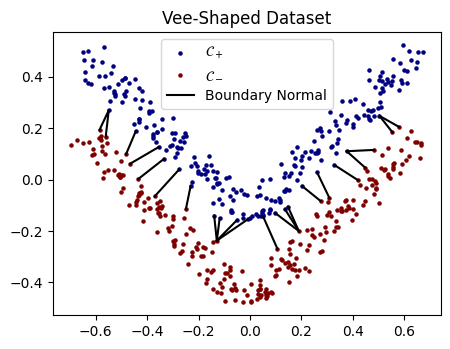

In [27]:
fig,ax=plt.subplots(nrows=1,ncols=1)
ax.set_aspect('equal')
fig.set_figwidth(5)
fig.set_figheight(5)

colors = plt.cm.jet(np.linspace(0,1,2))

ax.scatter(x=x[(y.T)[0]==1,0],y=x[(y.T)[0]==1,1],color=colors[0],label='$\\mathcal{C}_+$',s=5)
ax.scatter(x=x[(y.T)[0]==0,0],y=x[(y.T)[0]==0,1],color=colors[1],label='$\\mathcal{C}_-$',s=5)

for n,pair in enumerate(pairs):
    positive_latent=positive_latents[pair[0],:]
    negative_latent=negative_latents[pair[1],:]
    if n==0:
        ax.plot([negative_latent[0],positive_latent[0]],[negative_latent[1],positive_latent[1]],color='black',label='Boundary Normal')
    else:
        ax.plot([negative_latent[0],positive_latent[0]],[negative_latent[1],positive_latent[1]],color='black')

ax.legend()
ax.set_title(dataset_name)
plt.show()